#Import Dependencies and Data

***Mount Google Drive***

In [12]:
from google.colab import drive
drive.mount('/content/drive')

!pip install fuzzywuzzy
import nltk
nltk.download("stopwords")

import pandas as pd
import numpy as np
import spacy
import statistics
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from bs4 import BeautifulSoup

from tqdm.notebook import trange, tqdm
tqdm.pandas(desc="Progress")

# Now you can use `progress_apply` instead of `apply`
# and `progress_map` instead of `map`

import numpy as np
import matplotlib.pyplot as plt

import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
#Open Data in Pandas dataframe
path = '/content/drive/My Drive/Case Studies/Quora Question Pairs/train.csv'
#Loading data into pandas dataframe
df = pd.read_csv(path)

In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
# info() function to print full summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [0]:
#drop blank rows 
df.dropna(inplace=True)

# Basic Featurization

**Basic Features**

* Lenght of the questions1 & question2
* Occurance frequency of questions1 & question2
* Common minimum words
* Common max words
* Common minimum stopwords
* Common maximum stopwords
* First word equal
* Last word equal
* Absolute length difference
* Mean length

In [0]:
#Occurance frequency of question1
q1freq = df.question1.value_counts()
q1freq=q1freq.T.to_dict()
df['fre_q1'] = df.question1.progress_apply(lambda x: q1freq.get(x))

#Occurance frequency of question2
q2freq = df.question2.value_counts()
q2freq=q2freq.T.to_dict()
df['fre_q2'] = df.question2.progress_apply(lambda x: q2freq.get(x))

In [0]:
#Lenght of the questions1
df['q1_len'] = df.question1.progress_apply(lambda x: len(str(x)))

#Lenght of the questions2
df['q2_len'] = df.question2.progress_apply(lambda x: len(str(x)))

In [0]:
#common word between sentenses
#splitting word into sentences
df['q1_words'] = df.question1.progress_apply(lambda x: set(x.split()))
df['q2_words'] = df.question2.progress_apply(lambda x: set(x.split()))

#finding common words
df['common_words'] = df.progress_apply(lambda x: set(x['q1_words']).intersection(set(x['q2_words'])),axis=1)


#Common minimum stopwords
commom_words_min = []

for (a,b,c) in zip(df.common_words, df.q1_words, df.q2_words): 
    try:
        result = len(a)/min(len(b),len(c))
    except:
        result = np.NaN
        
    commom_words_min.append(result)

df['commom_words_min'] = commom_words_min



#Common max words

commom_words_max = []

for (a,b,c) in zip(df.common_words, df.q1_words, df.q2_words): 
    try:
        result = len(a)/min(len(b),len(c))
    except:
        result = np.NaN
        
    commom_words_max.append(result)

df['commom_words_max'] = commom_words_max

In [0]:
!nltk.download('stopwords')

/bin/bash: -c: line 0: syntax error near unexpected token `'stopwords''
/bin/bash: -c: line 0: `nltk.download('stopwords')'


In [0]:
#finding common stopwords in a question
from nltk.corpus import stopwords
stopwords.words('english')

english_stropwords = set(stopwords.words('english'))

#finding stopword in sentense

def stopwords_sentence(sen):
    stopwords_in_sentense = []
    for w in sen:
        if w in english_stropwords:
                stopwords_in_sentense.append(w)
    return stopwords_in_sentense


#finding stopword in question1 and question2

df['q1_stopwords'] = df.q1_words.progress_apply(lambda x: stopwords_sentence(x))
df['q2_stopwords'] = df.q2_words.progress_apply(lambda x: stopwords_sentence(x))


#common_stropword
df['common_stopwords'] = df.progress_apply(lambda x: set(x['q1_stopwords']).intersection(set(x['q2_stopwords'])),axis=1)


#Common minimum stopwords
commom_stopwords_min = []

for (a,b,c) in zip(df.common_stopwords, df.q1_stopwords, df.q2_stopwords): 
    try:
        result = len(a)/min(len(b),len(c))
    except:
        result = np.NaN
        
    commom_stopwords_min.append(result)

df['commom_stopwords_min'] = commom_stopwords_min



#Common maximum stopwords
commom_stopwords_max = []

for (a,b,c) in tqdm(zip(df.common_stopwords, df.q1_stopwords, df.q2_stopwords)): 
    try:
        result = len(a)/max(len(b),len(c))
    except:
        result = np.NaN
    commom_stopwords_max.append(result)

df['commom_stopwords_max'] = commom_stopwords_max

In [0]:
#first word equal
df['first_equal'] = df.question1.progress_apply(lambda x: x.split(' ', )[0])==df.question2.apply(lambda x: x.split(' ', )[0])
df['first_equal'] = df['first_equal'].replace(True,1)

In [0]:
#Last word equal
df['last_equal'] = df.question1.progress_apply(lambda x: x.split(' ', )[-1])==df.question2.apply(lambda x: x.split(' ', )[-1])
df['last_equal'] = df['last_equal'].replace(True,1)

In [0]:
#Absolute length difference
df['abslote_len_diff'] = df.progress_apply(lambda x: abs(x['q1_len']-x['q2_len']),axis=1)

#Mean length
df['mean_len']  = df.progress_apply(lambda x: statistics.mean([x['q1_len'],x['q2_len']]),axis=1)

# Test Pre-processing

**Preprocessing of Text**

* Removing html tags
* Removing Punctuations
* Performing stemming
* Removing Stopwords
* Expanding contractions etc.

In [0]:
# To get the results in 4 decemal points

SAFE_DIV = 0.0001 

#doing processing of text
def preprocess(x):
    
    #characters converting into lower
    x = str(x).lower()
    #replacing values

    #Expanding contraction
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    #doing stemming
    porter = PorterStemmer()
    pattern = re.compile('\W')
    #defining type
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [0]:
df["clean_question1"] = df["question1"].fillna("").progress_apply(preprocess)
df["clean_question2"] = df["question2"].fillna("").progress_apply(preprocess)

In [0]:
#Remove html tags from a string

def remove_html_tags(text):   
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [0]:
df["clean_question1"] = df["question1"].fillna("").progress_apply(remove_html_tags)
df["clean_question2"] = df["question2"].fillna("").progress_apply(remove_html_tags)

In [0]:
#Removing Punctuation

def remove_punctuation(string): 
    # punctuation marks 
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  
    # traverse the given string and if any punctuation 
    # marks occur replace it with null 
    for x in string.lower(): 
        if x in punctuations: 
            string = string.replace(x, "") 
  
    # Print string without punctuation 
    return string 

In [0]:
df["clean_question1"] = df["question1"].fillna("").progress_apply(remove_punctuation)
df["clean_question2"] = df["question2"].fillna("").progress_apply(remove_punctuation)

In [0]:
#Removing Stopwords

nltk.download('stopwords')
#loading stop words
en_stops = stopwords.words("english")

def remove_stopword(string):
  all_words = string.split()
  clean_string = []
  for word in all_words: 
      if word not in en_stops:
          clean_string.append(word)
  return clean_string


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df["clean_question1"] = df["question1"].fillna("").progress_apply(remove_stopword)
df["clean_question2"] = df["question2"].fillna("").progress_apply(remove_stopword)

In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,fre_q1,fre_q2,q1_len,q2_len,q1_words,q2_words,common_words,commom_words_min,commom_words_max,q1_stopwords,q2_stopwords,common_stopwords,commom_stopwords_min,commom_stopwords_max,first_equal,last_equal,abslote_len_diff,mean_len,clean_question1,clean_question2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,"{market, step, share, by, is, invest, What, th...","{step, share, by, is, invest, What, the, to, m...","{step, share, by, is, invest, What, the, to, g...",0.909091,0.909091,"[by, is, the, to, in]","[by, is, the, to, in]","{by, is, the, to, in}",1.00,1.000000,1.0,0.0,9,61.5,"[What, step, step, guide, invest, share, marke...","[What, step, step, guide, invest, share, market?]"
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,"{Kohinoor, (Koh-i-Noor), is, Diamond?, What, t...","{back?, Indian, Kohinoor, (Koh-i-Noor), govern...","{(Koh-i-Noor), What, the, Kohinoor}",0.500000,0.500000,"[is, the, of]","[the, if]",{the},0.50,0.333333,1.0,0.0,37,69.5,"[What, story, Kohinoor, (Koh-i-Noor), Diamond?]","[What, would, happen, Indian, government, stol..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,"{my, How, connection, speed, VPN?, internet, t...","{be, by, How, speed, Internet, increased, DNS?...","{can, How, speed}",0.300000,0.300000,"[my, the, while, can, of, a]","[be, by, can, through]",{can},0.25,0.166667,1.0,0.0,14,66.0,"[How, I, increase, speed, internet, connection...","[How, Internet, speed, increased, hacking, DNS?]"
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,"{Why, How, am, very, lonely?, can, it?, solve,...","{when, 24,23?, Find, by, remainder, [math]23^{...",{},0.000000,0.000000,"[am, very, can]","[when, by, is, the]",{},0.00,0.000000,0.0,0.0,15,57.5,"[Why, I, mentally, lonely?, How, I, solve, it?]","[Find, remainder, [math]23^{24}[/math], divide..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,"{di, Which, carbon, one, and, water, sugar,, d...","{Which, fish, salt, survive, would, water?, in}","{in, Which}",0.285714,0.285714,"[and, in]",[in],{in},1.00,0.500000,1.0,0.0,37,57.5,"[Which, one, dissolve, water, quikly, sugar,, ...","[Which, fish, would, survive, salt, water?]"


In [0]:
#saving clean data
#df.to_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/clean_train.csv')

# Simple Featurization

**Simple Features**

*   Fuzz Ratio
*   Fuzz Partial Ratio
*   Fuzz Token Sort Ratio
*   Token Set Ratio



In [0]:
#fuzz_ratio
#fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

df['fuzz_partial_ratio'] = df.progress_apply(lambda x: fuzz.partial_ratio(str(x['clean_question1']),str(x['clean_question2'])),axis=1)

#fuzz_partial_ratio
#fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


# Register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
# (can use `tqdm.gui.tqdm`, `tqdm.notebook.tqdm`, optional kwargs, etc.)

#df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['question1']),str(x['question2'])),axis=1)


df['fuzz_ratio'] = df.progress_apply(lambda x: fuzz.ratio(str(x['clean_question1']),str(x['clean_question2'])),axis=1)

#token_sort_ratio
#token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

df['fuzz_token_sort_ratio'] = df.progress_apply(lambda x: fuzz.token_sort_ratio(str(x['clean_question1']),str(x['clean_question2'])),axis=1)

#token_set_ratio
#token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

df['token_set_ratio'] = df.progress_apply(lambda x: fuzz.token_set_ratio(str(x['clean_question1']),str(x['clean_question2'])),axis=1)

In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,fre_q1,fre_q2,q1_len,q2_len,q1_words,q2_words,common_words,commom_words_min,commom_words_max,q1_stopwords,q2_stopwords,common_stopwords,commom_stopwords_min,commom_stopwords_max,first_equal,last_equal,abslote_len_diff,mean_len,clean_question1,clean_question2,fuzz_partial_ratio,fuzz_ratio,fuzz_token_sort_ratio,token_set_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,"{market, step, share, by, is, invest, What, th...","{step, share, by, is, invest, What, the, to, m...","{step, share, by, is, invest, What, the, to, g...",0.909091,0.909091,"[by, is, the, to, in]","[by, is, the, to, in]","{by, is, the, to, in}",1.00,1.000000,1.0,0.0,9,61.5,"[What, step, step, guide, invest, share, marke...","[What, step, step, guide, invest, share, market?]",97,93,93,100
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,"{Kohinoor, (Koh-i-Noor), is, Diamond?, What, t...","{back?, Indian, Kohinoor, (Koh-i-Noor), govern...","{(Koh-i-Noor), What, the, Kohinoor}",0.500000,0.500000,"[is, the, of]","[the, if]",{the},0.50,0.333333,1.0,0.0,37,69.5,"[What, story, Kohinoor, (Koh-i-Noor), Diamond?]","[What, would, happen, Indian, government, stol...",82,65,64,91
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,"{my, How, connection, speed, VPN?, internet, t...","{be, by, How, speed, Internet, increased, DNS?...","{can, How, speed}",0.300000,0.300000,"[my, the, while, can, of, a]","[be, by, can, through]",{can},0.25,0.166667,1.0,0.0,14,66.0,"[How, I, increase, speed, internet, connection...","[How, Internet, speed, increased, hacking, DNS?]",67,68,67,67
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,"{Why, How, am, very, lonely?, can, it?, solve,...","{when, 24,23?, Find, by, remainder, [math]23^{...",{},0.000000,0.000000,"[am, very, can]","[when, by, is, the]",{},0.00,0.000000,0.0,0.0,15,57.5,"[Why, I, mentally, lonely?, How, I, solve, it?]","[Find, remainder, [math]23^{24}[/math], divide...",38,40,25,30
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,"{di, Which, carbon, one, and, water, sugar,, d...","{Which, fish, salt, survive, would, water?, in}","{in, Which}",0.285714,0.285714,"[and, in]",[in],{in},1.00,0.500000,1.0,0.0,37,57.5,"[Which, one, dissolve, water, quikly, sugar,, ...","[Which, fish, would, survive, salt, water?]",53,39,48,63


In [0]:
df_basic_simple_features = df.drop(['id','qid1', 'qid2','is_duplicate','q1_words','q2_words','common_words','q1_stopwords','q2_stopwords','common_stopwords'], axis=1)

In [0]:
target =df['is_duplicate']

In [0]:
#Saving basic & simple features
#df_basic_simple_features.to_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/df_basic_simple_features1.csv')
#target.to_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/target1.csv')

# Splitting Data Into Train and Test

In [0]:
#Open Data in Pandas dataframe
#df_basic_simple_features_path = '/content/drive/My Drive/Case Studies/Quora Question Pairs/df_basic_simple_features1.csv'
#Loading data into pandas dataframe
#df_basic_simple_features = pd.read_csv(df_basic_simple_features_path, index_col=0)

In [0]:
#loading target file
#target = pd.read_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/clean_train.csv', index_col=0)

In [0]:
df_basic_simple_features.head()

,question1,question2,fre_q1,fre_q2,q1_len,q2_len,commom_words_min,commom_words_max,commom_stopwords_min,commom_stopwords_max,first_equal,last_equal,abslote_len_diff,mean_len,clean_question1,clean_question2,fuzz_partial_ratio,fuzz_ratio,fuzz_token_sort_ratio,token_set_ratio
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,1,1,66,57,0.909091,0.909091,1.00,1.000000,1.0,0.0,9,61.5,"['What', 'step', 'step', 'guide', 'invest', 's...","['What', 'step', 'step', 'guide', 'invest', 's...",97,93,93,100
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,4,1,51,88,0.500000,0.500000,0.50,0.333333,1.0,0.0,37,69.5,"['What', 'story', 'Kohinoor', '(Koh-i-Noor)', ...","['What', 'would', 'happen', 'Indian', 'governm...",82,65,64,91
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,1,1,73,59,0.300000,0.300000,0.25,0.166667,1.0,0.0,14,66.0,"['How', 'I', 'increase', 'speed', 'internet', ...","['How', 'Internet', 'speed', 'increased', 'hac...",67,68,67,67
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,1,1,50,65,0.000000,0.000000,0.00,0.000000,0.0,0.0,15,57.5,"['Why', 'I', 'mentally', 'lonely?', 'How', 'I'...","['Find', 'remainder', '[math]23^{24}[/math]', ...",38,40,25,30
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,3,1,76,39,0.285714,0.285714,1.00,0.500000,1.0,0.0,37,57.5,"['Which', 'one', 'dissolve', 'water', 'quikly'...","['Which', 'fish', 'would', 'survive', 'salt', ...",53,39,48,63


**Splitting Data into Test and Train**

In [0]:
X = df_basic_simple_features

#df.q2_td_idf_vec, df.q1_td_idf_vec,
#y =df['is_duplicate']
y =target['is_duplicate']

from sklearn.model_selection import train_test_split

#Splitting the data into train vs test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape )

(270872, 20) (270872,) (133415, 20) (133415,)


# Advance Featurization

**Advance Features**

*   Word Embedding - TF-IDF Weighted Word vector
1. Word Embedding of Training Data
2. Word Embedding of Test Data


In [0]:
#https://medium.com/@ranasinghiitkgp/featurization-of-text-data-bow-tf-idf-avgw2v-tfidf-weighted-w2v-7a6c62e8b097

#TFIDF vectorizer of Train Data

all_questions_train = list(X_train['question1']+X_train['question2'])


vectorizer = TfidfVectorizer(lowercase = False,)
vectorizer.fit_transform(all_questions_train)

# we are converting a dictionary with word as a key, and the idf as a value
train_tf_idf_dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))

In [0]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg
nlp = en_core_web_lg.load()

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
#vector dimention
print(nlp.vocab['What'].vector)

[-3.8548e-02  5.4252e-01 -2.1843e-01 -1.8855e-01  7.3000e-02  1.3180e-01
 -1.0402e-01  1.7231e-01 -5.1587e-02  2.8646e+00 -2.5131e-01 -1.9146e-01
  7.9987e-02  7.2892e-02 -1.3209e-01 -2.2971e-01 -1.7268e-01  8.3507e-01
 -3.8487e-01 -3.2492e-01  4.6680e-01 -1.5678e-01  1.0707e-01 -1.2479e-01
 -1.6030e-01 -5.2154e-03  1.5166e-02  1.6508e-01  9.8025e-02 -9.1898e-02
  2.4552e-04  4.4254e-01  1.6046e-01  1.2215e-01  1.2594e-01  3.1999e-01
  2.2045e-01  1.6870e-01 -3.8927e-01 -1.7347e-01 -1.3158e-01  7.9817e-02
 -5.8053e-02 -7.2235e-02  2.8033e-01  6.1080e-03 -3.9289e-01  6.1744e-04
 -3.3363e-02  7.5885e-03 -9.3664e-02  1.8932e-01 -2.2542e-01 -1.8091e-02
  2.9546e-01 -1.5163e-01 -1.5594e-01 -2.1939e-01  8.8317e-02 -6.5472e-02
 -6.2950e-02 -1.9989e-01 -4.9454e-03  2.9574e-01  2.7333e-01 -3.6213e-01
 -4.0510e-02  2.2045e-01  8.4721e-02  6.2764e-03  1.6914e-01 -2.0043e-01
  5.1647e-01 -1.1905e-01  7.8667e-02  2.6834e-01  6.6951e-02 -2.5118e-01
 -2.4145e-01  4.8134e-01  1.5448e-01  1.1538e-01 -9

In [0]:
q1_if_idf_train = []

#Word Embedding - TF-IDF Weighted Word vector for Q1
clean_question1 = X_train['question1'].tolist()

for q1 in tqdm(clean_question1):

    #Parse sentese loaded english model
    doc1 = nlp(q1)
    #Number of dimention of vector is 300
    mean_vec1 = np.zeros([len(doc1),300])
    for word1 in doc1:
        #fetching the vector value
        vec1 = word1.vector
        #fetching the idf value
        try:
            idf = train_tf_idf_dictionary[str(word1)]
        except:
            idf = 0
        
        #idf weighted vector
        mean_vec1 += vec1 *idf
    #Compute the final vector for a sentence is average vector all word vector
    mean_vec1 = mean_vec1.mean(axis = 0)
    q1_if_idf_train.append(mean_vec1)

In [0]:
q1_if_idf_train = pd.DataFrame(q1_if_idf_train)

In [0]:
dx=[]
for i in range(1,301):
  dx.append("x{}".format(i))
  i+=1

In [0]:
q1_if_idf_train.columns = dx
q1_if_idf_train.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,...,x261,x262,x263,x264,x265,x266,x267,x268,x269,x270,x271,x272,x273,x274,x275,x276,x277,x278,x279,x280,x281,x282,x283,x284,x285,x286,x287,x288,x289,x290,x291,x292,x293,x294,x295,x296,x297,x298,x299,x300
0,-1.847194,-3.637430,-5.603129,-0.727287,30.626644,3.033476,0.194983,-13.876139,-3.449426,187.589446,-28.373819,14.609311,-17.574474,17.319110,-2.235944,-7.164874,-24.343869,99.527991,17.786377,11.968240,-3.812978,-3.901518,-15.718585,8.067249,-2.056128,-13.495859,-14.449635,-8.734227,-1.906093,23.718380,12.447376,-4.587157,18.972613,-2.239290,-17.425948,9.803867,7.572692,-27.992144,9.200716,-14.374386,...,-2.672451,-0.413914,-6.724636,8.576202,-5.685232,-14.048069,-2.958856,15.371645,17.920086,-6.582300,-0.935944,9.658069,-1.522278,-2.819494,15.135022,10.742573,-3.833664,5.021263,11.415477,21.215910,-3.472704,11.895452,12.415728,10.386136,7.886070,-6.534182,-7.673025,5.045842,5.363437,-2.710323,-9.043248,18.160199,11.604071,-17.569351,22.089442,7.693569,-8.244256,11.227646,6.199702,23.380179
1,-3.682830,17.929202,-1.803958,-9.258313,9.851617,-8.394909,-5.425773,-6.425316,14.838611,151.347716,-11.318445,3.987185,-0.942331,-5.083498,2.756954,-0.912809,-5.532205,112.153388,-11.940551,0.172221,-10.063391,-2.292392,-0.196420,-4.493069,-10.098631,4.364957,-11.443235,0.502729,3.346322,16.059836,-8.813814,-0.120354,3.007205,3.096047,-9.999639,-3.293423,-20.935676,-5.029850,15.195116,-12.156024,...,1.676214,-2.377878,-4.277432,13.945037,19.398732,-10.003299,-0.304295,6.437216,29.192228,-11.564945,-3.627626,1.273606,1.299688,4.414719,-4.235450,-0.525759,-4.732567,4.571572,3.102748,-5.305700,1.151652,16.684668,-1.361288,-5.969451,13.248499,9.828358,2.946638,-13.463986,-0.594220,10.652352,-9.533786,6.446105,4.429418,1.183061,16.253626,2.496382,-11.699030,-1.991387,4.788531,4.529010
2,12.383856,21.983217,-2.544040,4.675335,-1.104703,28.420671,-17.157275,-1.383883,4.785708,178.267090,23.380437,25.070224,8.446840,10.920679,4.895966,1.623106,-13.587717,134.731443,-13.053211,-43.125265,-11.793591,-6.365919,-3.202071,-0.614666,23.620750,-1.504633,13.626937,6.219230,8.181566,-23.398599,-26.990680,17.584322,-12.972136,-16.044427,-0.968417,-15.320983,25.476324,3.365351,-14.398773,-2.337004,...,5.375580,9.628637,-8.078943,-1.612499,17.748815,16.166934,-5.632521,13.955929,59.001255,11.744749,10.537504,-4.226004,-24.567002,-16.016890,-17.127387,-11.210213,13.083499,-21.058545,-12.036918,27.439464,29.014690,22.556353,12.251245,-37.741066,-33.303364,-21.798840,-24.258306,-10.665011,9.038330,-16.044309,5.902871,-28.131028,16.506196,-25.278808,15.323525,3.348501,-3.249621,-2.733933,5.118749,-1.119881
3,-8.549885,0.631140,-3.450416,-6.895846,1.520256,0.326439,-7.452164,-8.697856,-3.161656,76.463888,-17.781723,2.561288,5.981488,-10.690050,-0.150234,-11.942054,-6.568974,60.479871,0.073648,8.217459,1.718223,2.865270,-8.570957,-0.458518,-15.935616,-6.951857,-8.347679,-11.776997,-1.529128,7.191423,-2.068740,-0.745761,-4.090813,20.582222,-14.672065,-0.684559,3.689084,1.841540,-0.421171,-6.129581,...,2.915834,-0.968668,-1.505792,16.332100,5.112812,-10.646139,7.651165,11.586419,1.635367,2.182392,-7.120192,1.292029,10.796436,9.694724,1.360745,6.485222,-8.851380,10.178168,9.465444,0.834810,-15.379974,0.741293,15.222710,3.099219,2.592505,-1.830786,4.230642,-11.443826,3.651919,-5.494528,-18.395220,-0.290734,-0.345159,-4.108988,-1.717673,-8.277633,-1.857622,-3.441840,-0.558815,16.187935
4,2.356131,6.721213,-7.542054,-7.405423,12.419738,8.507891,0.693756,-3.613822,-1.242728,44.691477,-7.510645,2.344626,-2.828772,-3.840565,-6.800762,-2.174989,-23.918600,28.741623,-6.983764,-6.041909,5.071502,9.601253,-5.455824,-1.557817,12.036876,0.954911,2.940980,1.442528,-4.218282,1.965471,5.631372,-0.181546,2.852965,-9.421074,2.904848,16.931325,-7.320306,-0.028011,-6.316789,-12.879168,...,17.919786,6.827742,-10.757706,6.683349,9.579

In [0]:
#q1_if_idf_train.to_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/q1_if_idf_train_1.csv')

In [0]:
q2_if_idf_train = []

#Word Embedding - TF-IDF Weighted Word vector for Q1
question2 = X_train['question2'].tolist()

for q2 in tqdm(question2):

    #Parse sentese loaded english model
    doc2 = nlp(q2)
    #Number of dimention of vector is 300
    mean_vec2 = np.zeros([len(doc2),300])
    for word2 in doc2:
        #fetching the vector value
        vec2 = word2.vector
        #fetching the idf value
        try:
            idf = train_tf_idf_dictionary[str(word2)]
        except:
            idf = 0
        
        #idf weighted vector
        mean_vec2 += vec2 *idf
    #Compute the final vector for a sentence is average vector all word vector
    mean_vec2 = mean_vec2.mean(axis = 0)
    q2_if_idf_train.append(mean_vec2)

In [0]:
q2_if_idf_train = pd.DataFrame(q2_if_idf_train)

In [0]:
dy=[]
for i in range(1,301):
  dy.append("y{}".format(i))
  i+=1

In [0]:
q2_if_idf_train.columns = dy
q2_if_idf_train.head()

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25,y26,y27,y28,y29,y30,y31,y32,y33,y34,y35,y36,y37,y38,y39,y40,...,y261,y262,y263,y264,y265,y266,y267,y268,y269,y270,y271,y272,y273,y274,y275,y276,y277,y278,y279,y280,y281,y282,y283,y284,y285,y286,y287,y288,y289,y290,y291,y292,y293,y294,y295,y296,y297,y298,y299,y300
0,-3.283602,0.226953,-10.910777,-3.009582,25.065185,-5.795166,3.387248,-6.071126,4.726447,85.133679,-35.169163,0.094862,-5.015193,0.722639,1.904348,-5.342573,-7.534838,52.523396,19.258003,6.506113,13.320044,0.616880,-0.167217,-3.647225,-11.373709,-6.735987,-6.983765,-3.125791,-4.621764,11.801453,6.695532,-3.443623,16.637039,12.092703,-4.422085,12.473780,-1.481644,-6.371908,-4.822132,-5.845821,...,3.765248,6.712961,-0.388013,9.564607,-0.017925,-13.835973,1.141786,7.346478,-1.898698,13.337731,-10.987519,3.774305,-3.178965,18.501030,5.077078,9.252969,2.619025,-0.879973,0.828349,-2.126997,-4.040883,0.648412,-5.443501,12.908215,1.496697,0.564584,-0.340800,-3.938865,5.903436,-0.827081,-1.291023,3.791354,-3.352169,-3.093458,5.444594,-2.611913,0.262422,2.745739,-1.199779,15.641695
1,-8.576378,17.346344,-3.618670,-5.883864,9.602489,-11.145319,-2.661163,-2.902344,13.315950,159.104487,-15.745637,5.575122,-1.744869,-4.504002,3.581521,0.646503,-6.433619,110.808431,-9.842639,0.373179,-10.363953,-1.351498,-2.031487,-5.807131,-9.724041,1.462723,-14.675287,1.239594,8.397139,12.329976,-4.602971,-2.613467,6.527386,3.677568,-8.601197,-5.758742,-24.587552,-8.167870,15.526618,-9.480444,...,6.202748,-3.436288,-1.169272,12.393502,18.183811,-10.526543,1.809963,5.275799,27.532099,-10.797961,2.052430,-0.822471,2.631587,3.594449,-9.494518,0.060886,-5.867993,3.063172,-0.583173,-1.166885,-1.443078,14.623356,-2.561791,-3.800461,11.370311,5.278475,0.345986,-12.431647,1.386257,12.275414,-14.260404,4.102602,7.046019,1.104683,13.066680,2.602819,-11.221503,-4.186856,4.615562,1.131568
2,0.009240,-6.992487,1.723520,-1.759159,-3.594097,3.456681,7.871865,-1.893811,4.340612,49.810144,-8.361565,-13.406823,-5.317631,0.415921,-4.987378,-0.505451,-5.240242,41.352895,-7.160277,-5.463938,-7.925191,-5.447165,3.857649,3.902378,-1.692038,-3.883238,-3.461786,-3.854620,9.870826,-3.715728,5.316316,-4.615571,-4.399149,13.857538,0.920673,1.042430,-6.799895,3.165065,-6.887846,-0.220254,...,8.341937,11.261264,-1.248260,-2.925250,1.590234,-2.074621,-4.635501,1.331472,11.159600,-4.424299,-4.868712,-0.384247,3.729723,-1.191977,4.092607,-6.537913,4.733443,1.669303,-1.023480,-0.012066,-0.155444,-1.513571,2.397135,2.941368,-2.144665,-11.937252,2.474682,-3.122493,9.197455,-4.810125,-6.401687,0.730506,-8.211861,2.435072,-1.925132,0.893712,-9.706436,2.453125,-1.819358,8.330688
3,-33.316862,24.124323,-2.853640,1.656417,0.114792,-9.037152,-0.710581,-33.362137,-9.366394,141.647849,-34.819947,2.480413,2.671425,-6.484909,15.115621,-12.738443,-10.411993,155.892763,5.592919,0.521017,-18.048008,10.537104,-25.226737,0.470940,-20.132710,5.438643,-27.032590,-5.180044,-16.224013,22.502570,17.281299,-10.008837,10.835035,15.317605,-23.275068,-2.088446,5.858738,3.186884,2.013671,-15.049206,...,13.588609,1.614982,11.526311,35.284682,0.092809,-25.277665,9.536447,12.615921,10.386678,13.779443,-30.216742,-2.117234,25.147720,23.943774,9.716420,3.032879,-26.924216,6.470664,6.969626,3.222704,-18.094096,1.673165,27.261570,15.255693,8.414070,-8.204280,-2.566972,-22.528183,16.122600,-12.763945,-28.908405,-3.083931,7.670998,-8.123042,-17.524882,-24.841636,-0.370066,4.119917,16.545180,36.117007
4,2.674597,5.836029,-6.047482,-7.506455,12.121628,8.658858,1.211910,-3.273417,-1.086735,37.509022,-6.641131,2.220319,-2.553141,-3.571643,-6.230967,-1.410193,-22.920791,24.567288,-5.574502,-6.161628,4.749901,9.655950,-4.917686,-1.258586,13.292368,0.743402,2.884780,1.874166,-4.750180,2.666004,5.046913,-1.012963,3.476729,-10.236245,3.195021,17.052630,-7.109096,-0.813682,-5.945935,-12.708356,...,17.648955,6.717032,-11.401195,7.027980,8.912501,-0.004302,0.265706,-0.091259,9.788752,0.

In [0]:
#q2_if_idf_train.to_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/q2_if_idf_train_1.csv')

In [0]:
X_train.head()

,question1,question2,fre_q1,fre_q2,q1_len,q2_len,commom_words_min,commom_words_max,commom_stopwords_min,commom_stopwords_max,first_equal,last_equal,abslote_len_diff,mean_len,clean_question1,clean_question2,fuzz_partial_ratio,fuzz_ratio,fuzz_token_sort_ratio,token_set_ratio
186150,"What is the difference between ""visa on arriva...",Do I need a visa to visit Ireland from England?,2,1,103,47,0.200000,0.200000,0.666667,0.250000,0.0,0.0,56,75.0,"[What, difference, ""visa, arrival"", ""visa, fre...","[Do, I, need, visa, visit, Ireland, England?]",49,42,41,37
208652,What are the chances of receiving invitation t...,What are the chances of receiving invitation t...,1,1,95,95,0.941176,0.941176,1.000000,1.000000,1.0,0.0,0,95.0,"[What, chances, receiving, invitation, apply, ...","[What, chances, receiving, invitation, apply, ...",99,99,98,98
268163,"Is the phrase ""the pressure in an incompressib...",What is the use of Bash in Windows?,1,1,150,35,0.250000,0.250000,0.500000,0.333333,0.0,0.0,115,92.5,"[Is, phrase, ""the, pressure, incompressible, f...","[What, use, Bash, Windows?]",54,23,13,13
155539,How do I buy goods from Amazon and ship to Vie...,How can I sell Vietnam traditional silk ties o...,2,1,51,109,0.454545,0.454545,0.250000,0.250000,1.0,1.0,58,80.0,"[How, I, buy, goods, Amazon, ship, Vietnam?]","[How, I, sell, Vietnam, traditional, silk, tie...",66,54,49,73
212779,How do you read tarot cards?,How do I read tarot cards?,1,1,28,26,0.833333,0.833333,1.000000,0.500000,1.0,1.0,2,27.0,"[How, read, tarot, cards?]","[How, I, read, tarot, cards?]",88,93,95,100


In [0]:
simplefeature_training = X_train.drop(['question1','question2','clean_question1','clean_question2'], axis=1)

In [0]:
simplefeature_training.head()

,fre_q1,fre_q2,q1_len,q2_len,commom_words_min,commom_words_max,commom_stopwords_min,commom_stopwords_max,first_equal,last_equal,abslote_len_diff,mean_len,fuzz_partial_ratio,fuzz_ratio,fuzz_token_sort_ratio,token_set_ratio
0,2,1,103,47,0.200000,0.200000,0.666667,0.250000,0.0,0.0,56,75.0,49,42,41,37
1,1,1,95,95,0.941176,0.941176,1.000000,1.000000,1.0,0.0,0,95.0,99,99,98,98
2,1,1,150,35,0.250000,0.250000,0.500000,0.333333,0.0,0.0,115,92.5,54,23,13,13
3,2,1,51,109,0.454545,0.454545,0.250000,0.250000,1.0,1.0,58,80.0,66,54,49,73
4,1,1,28,26,0.833333,0.833333,1.000000,0.500000,1.0,1.0,2,27.0,88,93,95,100


In [0]:
simplefeature_training.reset_index(inplace=True) 

In [0]:
simplefeature_training = simplefeature_training.drop(['index'],axis=1)

In [0]:
simplefeature_training.head()

,fre_q1,fre_q2,q1_len,q2_len,commom_words_min,commom_words_max,commom_stopwords_min,commom_stopwords_max,first_equal,last_equal,abslote_len_diff,mean_len,fuzz_partial_ratio,fuzz_ratio,fuzz_token_sort_ratio,token_set_ratio
0,2,1,103,47,0.200000,0.200000,0.666667,0.250000,0.0,0.0,56,75.0,49,42,41,37
1,1,1,95,95,0.941176,0.941176,1.000000,1.000000,1.0,0.0,0,95.0,99,99,98,98
2,1,1,150,35,0.250000,0.250000,0.500000,0.333333,0.0,0.0,115,92.5,54,23,13,13
3,2,1,51,109,0.454545,0.454545,0.250000,0.250000,1.0,1.0,58,80.0,66,54,49,73
4,1,1,28,26,0.833333,0.833333,1.000000,0.500000,1.0,1.0,2,27.0,88,93,95,100


In [0]:
print (simplefeature_training.shape, q1_if_idf_train.shape, q2_if_idf_train.shape, y_train.shape)

(270872, 16) (270872, 300) (270872, 300) (270872,)


In [0]:
x_train_concat = pd.concat([simplefeature_training, q1_if_idf_train,q2_if_idf_train], axis=1)

In [0]:
x_train_concat.shape

(270872, 616)

In [0]:
x_train_concat.head()

,fre_q1,fre_q2,q1_len,q2_len,commom_words_min,commom_words_max,commom_stopwords_min,commom_stopwords_max,first_equal,last_equal,abslote_len_diff,mean_len,fuzz_partial_ratio,fuzz_ratio,fuzz_token_sort_ratio,token_set_ratio,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,...,y261,y262,y263,y264,y265,y266,y267,y268,y269,y270,y271,y272,y273,y274,y275,y276,y277,y278,y279,y280,y281,y282,y283,y284,y285,y286,y287,y288,y289,y290,y291,y292,y293,y294,y295,y296,y297,y298,y299,y300
0,2,1,103,47,0.200000,0.200000,0.666667,0.250000,0.0,0.0,56,75.0,49,42,41,37,-1.847194,-3.637430,-5.603129,-0.727287,30.626644,3.033476,0.194983,-13.876139,-3.449426,187.589446,-28.373819,14.609311,-17.574474,17.319110,-2.235944,-7.164874,-24.343869,99.527991,17.786377,11.968240,-3.812978,-3.901518,-15.718585,8.067249,...,3.765248,6.712961,-0.388013,9.564607,-0.017925,-13.835973,1.141786,7.346478,-1.898698,13.337731,-10.987519,3.774305,-3.178965,18.501030,5.077078,9.252969,2.619025,-0.879973,0.828349,-2.126997,-4.040883,0.648412,-5.443501,12.908215,1.496697,0.564584,-0.340800,-3.938865,5.903436,-0.827081,-1.291023,3.791354,-3.352169,-3.093458,5.444594,-2.611913,0.262422,2.745739,-1.199779,15.641695
1,1,1,95,95,0.941176,0.941176,1.000000,1.000000,1.0,0.0,0,95.0,99,99,98,98,-3.682830,17.929202,-1.803958,-9.258313,9.851617,-8.394909,-5.425773,-6.425316,14.838611,151.347716,-11.318445,3.987185,-0.942331,-5.083498,2.756954,-0.912809,-5.532205,112.153388,-11.940551,0.172221,-10.063391,-2.292392,-0.196420,-4.493069,...,6.202748,-3.436288,-1.169272,12.393502,18.183811,-10.526543,1.809963,5.275799,27.532099,-10.797961,2.052430,-0.822471,2.631587,3.594449,-9.494518,0.060886,-5.867993,3.063172,-0.583173,-1.166885,-1.443078,14.623356,-2.561791,-3.800461,11.370311,5.278475,0.345986,-12.431647,1.386257,12.275414,-14.260404,4.102602,7.046019,1.104683,13.066680,2.602819,-11.221503,-4.186856,4.615562,1.131568
2,1,1,150,35,0.250000,0.250000,0.500000,0.333333,0.0,0.0,115,92.5,54,23,13,13,12.383856,21.983217,-2.544040,4.675335,-1.104703,28.420671,-17.157275,-1.383883,4.785708,178.267090,23.380437,25.070224,8.446840,10.920679,4.895966,1.623106,-13.587717,134.731443,-13.053211,-43.125265,-11.793591,-6.365919,-3.202071,-0.614666,...,8.341937,11.261264,-1.248260,-2.925250,1.590234,-2.074621,-4.635501,1.331472,11.159600,-4.424299,-4.868712,-0.384247,3.729723,-1.191977,4.092607,-6.537913,4.733443,1.669303,-1.023480,-0.012066,-0.155444,-1.513571,2.397135,2.941368,-2.144665,-11.937252,2.474682,-3.122493,9.197455,-4.810125,-6.401687,0.730506,-8.211861,2.435072,-1.925132,0.893712,-9.706436,2.453125,-1.819358,8.330688
3,2,1,51,109,0.454545,0.454545,0.250000,0.250000,1.0,1.0,58,80.0,66,54,49,73,-8.549885,0.631140,-3.450416,-6.895846,1.520256,0.326439,-7.452164,-8.697856,-3.161656,76.463888,-17.781723,2.561288,5.981488,-10.690050,-0.150234,-11.942054,-6.568974,60.479871,0.073648,8.217459,1.718223,2.865270,-8.570957,-0.458518,...,13.588609,1.614982,11.526311,35.284682,0.092809,-25.277665,9.536447,12.615921,10.386678,13.779443,-30.216742,-2.117234,25.147720,23.943774,9.716420,3.032879,-26.924216,6.470664,6.969626,3.222704,-18.094096,1.673165,27.261570,15.255693,8.414070,-8.204280,-2.566972,-22.528183,16.122600,-12.763945,-28.908405,-3.083931,7.670998,-8.123042,-17.524882,-24.841636,-0.370066,4.119917,16.545180,36.117007
4,1,1,28,26,0.833333,0.833333,1.000000,0.500000,1.0,1.0,2,27.0,88,93,95,100,2.356131,6.721213,-7.542054,-7.405423,12.419738,8.507891,0.693756,-3.613822,-1.242728,44.691477,-7.510645,2.344626,-2.828772,-3.840565,-6.800762,-2.174989,-23.918600,28.741623,-6.983764,-6.041909,5.071502,9.601253,-5.455824,-1.557817,...,17.648955,6.717032,-11.401195,7.027980,8.912501,-0.004302,0.265706,-0.091259,9.788752,0.789348,-30.010870,7.295165,-8.524108,18.150140,2.284912,5.259600,-8.455570,-4.397908,-2.608958,-1.780612,-2.799843,-4.983436,6.368407,-12.864065,10.790150,18.116888,-4.694254,-3.058424,0.652310,3.863187,-16.967265,6.906936,-1.173505,0.661291,6.6619

In [0]:
#x_train_concat.to_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/x_train_concat.csv')

In [0]:
#x_train_concat = pd.read_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/x_train_concat.csv', index_col=0)

In [0]:
y_train

186150    0
208652    0
268163    0
155539    0
212779    0
         ..
259180    0
365841    0
131933    1
146868    0
121959    0
Name: is_duplicate, Length: 270872, dtype: int64

In [0]:
x_train_concat.head()

,fre_q1,fre_q2,q1_len,q2_len,commom_words_min,commom_words_max,commom_stopwords_min,commom_stopwords_max,first_equal,last_equal,abslote_len_diff,mean_len,fuzz_partial_ratio,fuzz_ratio,fuzz_token_sort_ratio,token_set_ratio,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,...,y261,y262,y263,y264,y265,y266,y267,y268,y269,y270,y271,y272,y273,y274,y275,y276,y277,y278,y279,y280,y281,y282,y283,y284,y285,y286,y287,y288,y289,y290,y291,y292,y293,y294,y295,y296,y297,y298,y299,y300
0,2,1,103,47,0.200000,0.200000,0.666667,0.250000,0.0,0.0,56,75.0,49,42,41,37,-1.847194,-3.637430,-5.603129,-0.727287,30.626644,3.033476,0.194983,-13.876139,-3.449426,187.589446,-28.373819,14.609311,-17.574474,17.319110,-2.235944,-7.164874,-24.343869,99.527991,17.786377,11.968240,-3.812978,-3.901518,-15.718585,8.067249,...,3.765248,6.712961,-0.388013,9.564607,-0.017925,-13.835973,1.141786,7.346478,-1.898698,13.337731,-10.987519,3.774305,-3.178965,18.501030,5.077078,9.252969,2.619025,-0.879973,0.828349,-2.126997,-4.040883,0.648412,-5.443501,12.908215,1.496697,0.564584,-0.340800,-3.938865,5.903436,-0.827081,-1.291023,3.791354,-3.352169,-3.093458,5.444594,-2.611913,0.262422,2.745739,-1.199779,15.641695
1,1,1,95,95,0.941176,0.941176,1.000000,1.000000,1.0,0.0,0,95.0,99,99,98,98,-3.682830,17.929202,-1.803958,-9.258313,9.851617,-8.394909,-5.425773,-6.425316,14.838611,151.347716,-11.318445,3.987185,-0.942331,-5.083498,2.756954,-0.912809,-5.532205,112.153388,-11.940551,0.172221,-10.063391,-2.292392,-0.196420,-4.493069,...,6.202748,-3.436288,-1.169272,12.393502,18.183811,-10.526543,1.809963,5.275799,27.532099,-10.797961,2.052430,-0.822471,2.631587,3.594449,-9.494518,0.060886,-5.867993,3.063172,-0.583173,-1.166885,-1.443078,14.623356,-2.561791,-3.800461,11.370311,5.278475,0.345986,-12.431647,1.386257,12.275414,-14.260404,4.102602,7.046019,1.104683,13.066680,2.602819,-11.221503,-4.186856,4.615562,1.131568
2,1,1,150,35,0.250000,0.250000,0.500000,0.333333,0.0,0.0,115,92.5,54,23,13,13,12.383856,21.983217,-2.544040,4.675335,-1.104703,28.420671,-17.157275,-1.383883,4.785708,178.267090,23.380437,25.070224,8.446840,10.920679,4.895966,1.623106,-13.587717,134.731443,-13.053211,-43.125265,-11.793591,-6.365919,-3.202071,-0.614666,...,8.341937,11.261264,-1.248260,-2.925250,1.590234,-2.074621,-4.635501,1.331472,11.159600,-4.424299,-4.868712,-0.384247,3.729723,-1.191977,4.092607,-6.537913,4.733443,1.669303,-1.023480,-0.012066,-0.155444,-1.513571,2.397135,2.941368,-2.144665,-11.937252,2.474682,-3.122493,9.197455,-4.810125,-6.401687,0.730506,-8.211861,2.435072,-1.925132,0.893712,-9.706436,2.453125,-1.819358,8.330688
3,2,1,51,109,0.454545,0.454545,0.250000,0.250000,1.0,1.0,58,80.0,66,54,49,73,-8.549885,0.631140,-3.450416,-6.895846,1.520256,0.326439,-7.452164,-8.697856,-3.161656,76.463888,-17.781723,2.561288,5.981488,-10.690050,-0.150234,-11.942054,-6.568974,60.479871,0.073648,8.217459,1.718223,2.865270,-8.570957,-0.458518,...,13.588609,1.614982,11.526311,35.284682,0.092809,-25.277665,9.536447,12.615921,10.386678,13.779443,-30.216742,-2.117234,25.147720,23.943774,9.716420,3.032879,-26.924216,6.470664,6.969626,3.222704,-18.094096,1.673165,27.261570,15.255693,8.414070,-8.204280,-2.566972,-22.528183,16.122600,-12.763945,-28.908405,-3.083931,7.670998,-8.123042,-17.524882,-24.841636,-0.370066,4.119917,16.545180,36.117007
4,1,1,28,26,0.833333,0.833333,1.000000,0.500000,1.0,1.0,2,27.0,88,93,95,100,2.356131,6.721213,-7.542054,-7.405423,12.419738,8.507891,0.693756,-3.613822,-1.242728,44.691477,-7.510645,2.344626,-2.828772,-3.840565,-6.800762,-2.174989,-23.918600,28.741623,-6.983764,-6.041909,5.071502,9.601253,-5.455824,-1.557817,...,17.648955,6.717032,-11.401195,7.027980,8.912501,-0.004302,0.265706,-0.091259,9.788752,0.789348,-30.010870,7.295165,-8.524108,18.150140,2.284912,5.259600,-8.455570,-4.397908,-2.608958,-1.780612,-2.799843,-4.983436,6.368407,-12.864065,10.790150,18.116888,-4.694254,-3.058424,0.652310,3.863187,-16.967265,6.906936,-1.173505,0.661291,6.6619

In [0]:
print(x_train_concat.shape, y_train.shape,X_test.shape,y_test.shape )

(270872, 616) (270872,) (133415, 20) (133415,)


# Preparing Test Data - Advance Features

In [0]:
X_test.head()

,question1,question2,fre_q1,fre_q2,q1_len,q2_len,commom_words_min,commom_words_max,commom_stopwords_min,commom_stopwords_max,first_equal,last_equal,abslote_len_diff,mean_len,clean_question1,clean_question2,fuzz_partial_ratio,fuzz_ratio,fuzz_token_sort_ratio,token_set_ratio
8067,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,2,2,34,34,0.875000,0.875000,1.000000,1.0,1.0,0.0,0,34.0,"['How', 'I', 'play', 'Pokémon', 'GO', 'Korea?']","['How', 'I', 'play', 'Pokémon', 'GO', 'China?']",91,91,77,87
224279,Will a breathing treatment help a cough?,How can I help someone that is unconscious but...,1,1,40,63,0.166667,0.166667,0.000000,0.0,0.0,0.0,23,51.5,"['Will', 'breathing', 'treatment', 'help', 'co...","['How', 'I', 'help', 'someone', 'unconscious',...",54,35,54,59
252452,Is Kellyanne Conway annoying in your opinion?,Did Kellyanne Conway really imply that we shou...,2,1,45,118,0.285714,0.285714,0.000000,0.0,0.0,0.0,73,81.5,"['Is', 'Kellyanne', 'Conway', 'annoying', 'opi...","['Did', 'Kellyanne', 'Conway', 'really', 'impl...",70,51,47,62
174039,How do you rate (1-10) and review Maruti Baleno?,What career options does one have after comple...,1,1,48,127,0.000000,0.000000,0.000000,0.0,0.0,0.0,79,87.5,"['How', 'rate', '(1-10)', 'review', 'Maruti', ...","['What', 'career', 'options', 'one', 'completi...",56,36,27,27
384863,What are some good books on marketing?,What are some of the best books ever written a...,1,2,38,61,0.714286,0.714286,0.666667,0.4,1.0,1.0,23,49.5,"['What', 'good', 'books', 'marketing?']","['What', 'best', 'books', 'ever', 'written', '...",64,72,67,89


In [0]:
#https://medium.com/@ranasinghiitkgp/featurization-of-text-data-bow-tf-idf-avgw2v-tfidf-weighted-w2v-7a6c62e8b097

#TFIDF vectorizer of Train Data

all_questions_test = list(X_test['question1']+X_test['question2'])


vectorizer = TfidfVectorizer(lowercase = False,)
vectorizer.fit_transform(all_questions_test)

# we are converting a dictionary with word as a key, and the idf as a value
test_tf_idf_dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))

In [0]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg
nlp = en_core_web_lg.load()

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
#vector dimention
print(nlp.vocab['quora'].vector)

[ 4.8459e-01  4.6169e-01 -2.1170e-01 -7.5673e-02 -1.7142e-01  7.7150e-02
  3.4325e-01  2.8370e-01  2.3456e-01 -1.3706e+00 -3.6040e-02 -3.9399e-01
 -9.8439e-03 -3.4218e-02  9.6894e-02  1.8975e-01  1.3133e-01 -8.6004e-01
 -3.0124e-01 -6.9319e-01  8.8795e-02  5.4965e-01 -2.9896e-01 -3.1018e-01
  4.1148e-02  1.5636e-01  2.0499e-02  5.6856e-01  1.5134e-01  1.1983e-01
  5.6952e-01  8.6572e-02  4.6120e-03 -7.0019e-01 -1.7185e-01 -3.4021e-02
 -3.5350e-01 -2.8757e-01 -5.3226e-01 -5.1167e-01  2.0358e-01  1.8643e-01
 -5.3614e-01  1.5156e-01 -1.3370e-01  4.0838e-02  3.9929e-01 -1.7238e-01
 -7.6781e-01 -7.9972e-01 -7.8515e-02  4.8542e-01 -1.8784e-01 -2.3437e-01
 -1.6805e-01 -6.6387e-01  2.0222e-02 -4.7407e-01 -2.9818e-01  3.4813e-01
 -5.3295e-01  2.6930e-02  1.1057e+00 -3.1057e-01  3.9304e-01  3.8113e-02
 -3.4982e-01 -6.0487e-01 -3.5295e-01 -3.6092e-01 -5.7271e-01  4.2569e-02
  7.1989e-02  2.0375e-01  6.6481e-01 -4.6728e-01 -1.8090e-01  5.2283e-02
 -1.9289e-01 -5.1315e-01  7.6727e-02  3.6157e-01  1

In [0]:
q1_if_idf_test = []

#Word Embedding - TF-IDF Weighted Word vector for Q1
clean_question1 = X_test['question1'].tolist()

for q1 in tqdm(clean_question1):

    #Parse sentese loaded english model
    doc1 = nlp(q1)
    #Number of dimention of vector is 300
    mean_vec1 = np.zeros([len(doc1),300])
    for word1 in doc1:
        #fetching the vector value
        vec1 = word1.vector
        #fetching the idf value
        try:
            idf = test_tf_idf_dictionary[str(word1)]
        except:
            idf = 0
        
        #idf weighted vector
        mean_vec1 += vec1 *idf
    #Compute the final vector for a sentence is average vector all word vector
    mean_vec1 = mean_vec1.mean(axis = 0)
    q1_if_idf_test.append(mean_vec1)

In [0]:
q1_if_idf_test = pd.DataFrame(q1_if_idf_test)

In [0]:
dx=[]
for i in range(1,301):
  dx.append("x{}".format(i))
  i+=1

In [0]:
q1_if_idf_test.columns = dx
q1_if_idf_test.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,...,x261,x262,x263,x264,x265,x266,x267,x268,x269,x270,x271,x272,x273,x274,x275,x276,x277,x278,x279,x280,x281,x282,x283,x284,x285,x286,x287,x288,x289,x290,x291,x292,x293,x294,x295,x296,x297,x298,x299,x300
0,0.016334,0.042074,-4.225489,-0.806540,13.237108,-1.791016,2.260358,-1.056808,0.549615,47.064423,-15.315952,-3.245422,4.206232,-0.223098,1.594479,-0.099853,0.130772,20.910655,-7.974129,-3.017276,12.531789,-1.917410,4.024418,-8.631601,-1.466013,7.823051,-2.426410,-8.705566,2.752966,-1.425082,-2.388123,-4.837921,-0.398884,2.320125,-0.566723,-2.122684,5.840451,6.088728,-1.817455,-6.211265,...,4.164983,6.311063,-4.678114,-0.759472,-2.466774,-7.016336,-0.063317,-0.526264,1.842796,8.664639,-6.433981,-4.446774,-0.156334,3.049092,-2.892469,8.515093,-2.225713,2.265704,-2.663082,4.549598,-6.057862,0.422016,-5.817771,-12.046271,-2.359917,4.654662,0.367429,-8.287355,0.348056,0.568484,5.599344,7.646247,-2.942847,-3.084653,13.032106,11.225327,-5.372599,5.572101,6.646183,11.995718
1,-9.230129,9.979374,-15.775012,3.100145,-13.174388,-25.271157,2.399107,-15.675065,7.494756,78.417267,-6.047528,3.852619,3.490519,-8.684915,8.307918,4.036182,7.732434,46.452756,-15.266383,-1.226478,-5.923021,10.689335,-15.324742,-8.377704,-4.619609,-5.485433,11.995827,-14.137218,9.112670,-12.672864,-6.821382,-0.268627,-6.118670,-3.027756,4.970424,11.016252,-1.812500,0.041602,-2.837245,0.181440,...,-7.251800,-12.615793,6.109148,3.662703,10.750543,5.758101,-17.385467,3.839096,9.916182,7.465541,21.779240,1.600135,-18.287135,2.542285,-6.096023,-7.016317,-5.746473,1.633147,4.234296,15.109488,-6.063665,4.380185,2.816314,-3.860796,0.966724,5.349777,3.619376,-7.303372,19.939695,4.171229,-0.022557,-0.344807,-2.241765,-4.342034,4.144971,-5.698155,4.229672,5.073029,1.365098,11.356150
2,-11.463086,10.319908,-10.666429,-3.895966,8.751329,-0.534901,7.814743,-11.038218,6.424846,48.893713,-8.483275,-9.340017,3.145516,-3.896437,-3.602726,-9.424555,3.393869,17.242497,-6.217431,-0.357246,0.990595,-3.877037,3.048060,-12.326792,9.269979,-7.231975,-7.291370,-1.518232,4.589873,-1.447269,1.670760,16.224497,-12.638436,7.709889,-6.808349,1.671787,1.776575,-0.556550,-10.539169,-1.198790,...,-6.749380,-2.864053,6.010180,-2.353468,-3.073176,-6.325858,-2.934927,1.801908,11.857629,6.142340,-11.039219,0.355936,-6.607766,-3.111983,1.333766,-0.131458,0.547134,-9.264852,-1.152682,-6.192705,-0.476026,3.211506,-6.277923,4.424913,-4.890624,-2.404621,0.587513,-4.667616,-1.455962,-9.600493,6.550939,-3.128959,-9.216521,-0.919306,5.199927,2.780627,0.080081,2.978255,-8.167620,7.681651
3,-14.549750,19.314812,-1.715630,-5.025165,-4.831390,-6.266434,7.762332,-7.984673,0.174990,39.465358,-15.632348,-3.774041,2.647319,0.457025,-12.127535,-2.567641,-8.945733,39.985729,-5.842518,-1.252598,2.381419,-3.628217,3.687436,-8.226565,-3.594411,18.328211,-10.490890,-3.245140,14.563899,11.751254,6.275219,-2.997002,1.888908,3.735867,-9.014152,0.582478,-6.457753,-4.501593,-8.388570,-9.833139,...,-0.437649,-2.613252,-1.900995,0.448928,-2.386853,-17.249200,3.519850,16.612808,6.200608,2.404024,-1.323521,-10.714583,3.407710,-4.333003,-0.407678,8.197041,4.032153,-1.519748,2.512309,11.829645,-14.847671,6.157063,-1.534944,-0.215906,-2.078223,2.151141,11.638760,-0.397255,4.375358,3.350079,-8.924414,-2.569279,1.172625,-3.624448,6.779148,-7.981287,-6.158010,0.751566,2.069782,9.769310
4,-6.930115,7.586956,-6.850234,-3.588960,0.821111,5.082212,-1.311823,-5.387134,1.291605,64.049691,-12.154507,1.408424,2.653733,-5.194728,0.778564,-4.745985,-1.738666,33.772570,-4.542172,0.226793,2.005532,4.915168,-1.364392,-1.266328,2.399249,-2.646271,-2.438435,1.083325,0.063369,-0.741108,1.196509,-1.403828,2.012526,1.075059,2.051616,1.887990,-0.285885,2.934015,-3.669489,-4.117316,...,7.171800,2.053294,-1.800768,12.218220,9.304068,-4.786491,2.437014,3.090654,17.343352,0.908359,-11.699018,-3.418030,-2.68703

In [0]:
#q1_if_idf_test.to_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/q1_if_idf_test1.csv')

In [0]:
q2_if_idf_test = []

#Word Embedding - TF-IDF Weighted Word vector for Q2
clean_question2 = X_test['question2'].tolist()

for q2 in tqdm(clean_question2):

    #Parse sentese loaded english model
    doc2 = nlp(q2)
    #Number of dimention of vector is 300
    mean_vec2 = np.zeros([len(doc2),300])
    for word2 in doc2:
        #fetching the vector value
        vec2 = word2.vector
        #fetching the idf value
        try:
            idf = test_tf_idf_dictionary[str(word2)]
        except:
            idf = 0
        
        #idf weighted vector
        mean_vec2 += vec2 *idf
    #Compute the final vector for a sentence is average vector all word vector
    mean_vec2 = mean_vec2.mean(axis = 0)
    q2_if_idf_test.append(mean_vec2)

In [0]:
q2_if_idf_test = pd.DataFrame(q2_if_idf_test)

In [0]:
dy=[]
for i in range(1,301):
  dy.append("y{}".format(i))
  i+=1

In [0]:
q2_if_idf_test.columns = dy
q2_if_idf_test.head()

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20,y21,y22,y23,y24,y25,y26,y27,y28,y29,y30,y31,y32,y33,y34,y35,y36,y37,y38,y39,y40,...,y261,y262,y263,y264,y265,y266,y267,y268,y269,y270,y271,y272,y273,y274,y275,y276,y277,y278,y279,y280,y281,y282,y283,y284,y285,y286,y287,y288,y289,y290,y291,y292,y293,y294,y295,y296,y297,y298,y299,y300
0,-2.817533,0.289299,-8.396774,-5.635511,12.037144,0.832954,-0.281391,-1.340513,0.400367,48.614443,-12.912169,-2.589124,0.852144,1.524677,3.091528,0.868109,-1.903356,23.687978,-7.233263,-8.383832,7.499853,-0.977206,1.875550,-8.834263,0.543120,7.838869,-1.406049,-1.595761,1.213480,-3.888532,-2.227775,-0.994511,-1.054653,2.426871,0.480851,-0.904981,6.421041,3.273478,-0.012999,-8.515702,...,5.798072,9.605756,-2.790787,3.301326,-0.551441,-6.009236,-3.762458,-1.406878,4.413375,5.434665,-4.408568,-2.704984,0.763093,2.240587,-2.256031,7.171644,-2.763548,4.298591,1.702576,3.923407,-7.720452,0.843324,-5.363302,-10.118655,-1.348598,4.047491,2.857515,-6.809417,-1.482348,0.381376,1.641898,6.244284,-3.445763,-1.174988,10.767702,9.583782,-2.232470,5.813049,2.798010,13.577633
1,-2.023078,15.431196,-18.957677,12.970616,-1.215214,-7.665147,-9.558899,-10.768246,2.418809,127.885597,3.095334,7.845685,6.865663,-4.756534,-2.656596,1.726607,-4.178742,47.033366,-15.123101,-2.535103,1.322182,2.835491,-11.429984,-9.097319,-3.203669,3.291763,14.989770,-7.971917,6.966592,-17.431372,-11.604454,2.488416,-8.491746,-4.560476,6.444046,4.257506,0.636412,5.714931,-11.220805,-14.496545,...,-2.967132,-0.754893,6.578823,-2.711994,9.292644,8.388583,-16.451914,6.277685,10.275058,11.339820,12.655121,-1.871474,-15.101418,-4.369768,-6.269020,-4.092864,-6.054343,-1.904082,2.082579,15.086472,1.516302,-5.762101,0.372578,-6.380477,4.216756,-1.992155,3.997779,-3.818141,19.192257,-5.941366,-10.504826,-4.602055,1.411004,-1.607149,5.972194,8.478400,-6.178288,7.030079,5.833512,5.013763
2,-19.891229,13.964032,-25.038325,-19.865335,5.634953,2.206167,2.513910,-1.167239,8.648628,230.601247,-16.872913,-6.195019,20.855289,-3.719897,-18.848926,-5.216988,-8.489923,74.477407,-30.582459,-2.215459,14.166508,3.746443,5.781938,-13.074924,8.269818,-12.903829,-13.177054,-2.898821,0.259972,-5.139889,-10.394450,21.589457,-13.889216,8.588440,1.906929,-2.339042,-4.810349,1.792081,-26.413535,4.400504,...,1.430489,7.182287,-9.046792,18.417771,23.204676,-1.268323,2.365842,14.888319,27.829113,14.514339,-8.526870,4.510057,-3.482852,0.739765,-1.529253,-6.424318,2.675738,-2.923671,0.105718,11.546753,4.133239,6.053207,0.003812,4.243751,-14.013202,-8.190554,4.911467,1.760201,1.252256,-7.434391,-14.619076,3.322495,-22.242381,-5.566966,17.467449,6.218004,-8.245173,1.828070,6.370503,13.205994
3,18.653713,9.389006,3.571636,-14.266768,27.059745,-1.874681,-20.985700,-7.097460,8.521120,235.951467,-44.495000,12.455825,-11.157807,4.401717,9.217206,-6.512074,12.796113,128.159378,-15.112650,4.303207,-9.739441,-3.437630,-22.794444,-3.823251,16.848017,5.147870,9.482617,5.640160,-0.653389,33.943111,-1.104383,-3.583795,10.877627,-6.119397,-1.221063,-15.027939,-1.386104,-2.912413,-0.475184,-3.098186,...,17.221143,14.700307,20.540241,10.749859,13.758886,-19.725851,1.874676,-7.535445,13.443182,-2.618731,-29.155989,5.542621,3.464861,-9.571940,-10.189733,19.060747,8.649623,-9.030732,2.432896,5.668470,6.436782,0.672099,-1.488020,6.832890,7.071331,-30.247181,3.194539,-7.317591,11.351257,9.548858,11.173235,13.149283,8.418182,-0.994782,15.610309,-3.406345,-25.288618,10.996672,6.585324,3.973687
4,-8.671034,9.485735,-6.874347,-7.782973,2.725875,10.560863,1.207031,-4.849853,4.653009,106.864643,-11.794574,2.368571,3.793743,-3.438229,0.296958,-9.889615,-0.234590,44.159513,-8.607578,-5.364801,6.264376,0.670405,-1.643591,-0.945476,1.888045,-0.839115,-1.755802,0.617349,-3.210449,0.307001,1.569389,0.796997,-1.470144,3.291574,1.875252,2.261245,-2.975782,5.869743,-4.552506,-1.589677,...,12.099934,-0.650174,-5.423793,17.324827,13.278616,-8.134591,4.139084,6.293815,28.651101,-0.381097,-10.966

In [0]:
#q2_if_idf_test.to_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/q2_if_idf_test.csv')

In [0]:
X_test.head()

,question1,question2,fre_q1,fre_q2,q1_len,q2_len,commom_words_min,commom_words_max,commom_stopwords_min,commom_stopwords_max,first_equal,last_equal,abslote_len_diff,mean_len,clean_question1,clean_question2,fuzz_partial_ratio,fuzz_ratio,fuzz_token_sort_ratio,token_set_ratio
8067,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,2,2,34,34,0.875000,0.875000,1.000000,1.0,1.0,0.0,0,34.0,"['How', 'I', 'play', 'Pokémon', 'GO', 'Korea?']","['How', 'I', 'play', 'Pokémon', 'GO', 'China?']",91,91,77,87
224279,Will a breathing treatment help a cough?,How can I help someone that is unconscious but...,1,1,40,63,0.166667,0.166667,0.000000,0.0,0.0,0.0,23,51.5,"['Will', 'breathing', 'treatment', 'help', 'co...","['How', 'I', 'help', 'someone', 'unconscious',...",54,35,54,59
252452,Is Kellyanne Conway annoying in your opinion?,Did Kellyanne Conway really imply that we shou...,2,1,45,118,0.285714,0.285714,0.000000,0.0,0.0,0.0,73,81.5,"['Is', 'Kellyanne', 'Conway', 'annoying', 'opi...","['Did', 'Kellyanne', 'Conway', 'really', 'impl...",70,51,47,62
174039,How do you rate (1-10) and review Maruti Baleno?,What career options does one have after comple...,1,1,48,127,0.000000,0.000000,0.000000,0.0,0.0,0.0,79,87.5,"['How', 'rate', '(1-10)', 'review', 'Maruti', ...","['What', 'career', 'options', 'one', 'completi...",56,36,27,27
384863,What are some good books on marketing?,What are some of the best books ever written a...,1,2,38,61,0.714286,0.714286,0.666667,0.4,1.0,1.0,23,49.5,"['What', 'good', 'books', 'marketing?']","['What', 'best', 'books', 'ever', 'written', '...",64,72,67,89


In [0]:
simplefeature_test = X_test.drop(['question1','question2','clean_question1','clean_question2'], axis=1)

In [0]:
simplefeature_test.head()

,fre_q1,fre_q2,q1_len,q2_len,commom_words_min,commom_words_max,commom_stopwords_min,commom_stopwords_max,first_equal,last_equal,abslote_len_diff,mean_len,fuzz_partial_ratio,fuzz_ratio,fuzz_token_sort_ratio,token_set_ratio
8067,2,2,34,34,0.875000,0.875000,1.000000,1.0,1.0,0.0,0,34.0,91,91,77,87
224279,1,1,40,63,0.166667,0.166667,0.000000,0.0,0.0,0.0,23,51.5,54,35,54,59
252452,2,1,45,118,0.285714,0.285714,0.000000,0.0,0.0,0.0,73,81.5,70,51,47,62
174039,1,1,48,127,0.000000,0.000000,0.000000,0.0,0.0,0.0,79,87.5,56,36,27,27
384863,1,2,38,61,0.714286,0.714286,0.666667,0.4,1.0,1.0,23,49.5,64,72,67,89


In [0]:
simplefeature_test.reset_index(inplace=True) 

In [0]:
simplefeature_test = simplefeature_test.drop(['index'],axis=1)

In [0]:
simplefeature_test.head()

,fre_q1,fre_q2,q1_len,q2_len,commom_words_min,commom_words_max,commom_stopwords_min,commom_stopwords_max,first_equal,last_equal,abslote_len_diff,mean_len,fuzz_partial_ratio,fuzz_ratio,fuzz_token_sort_ratio,token_set_ratio
0,2,2,34,34,0.875000,0.875000,1.000000,1.0,1.0,0.0,0,34.0,91,91,77,87
1,1,1,40,63,0.166667,0.166667,0.000000,0.0,0.0,0.0,23,51.5,54,35,54,59
2,2,1,45,118,0.285714,0.285714,0.000000,0.0,0.0,0.0,73,81.5,70,51,47,62
3,1,1,48,127,0.000000,0.000000,0.000000,0.0,0.0,0.0,79,87.5,56,36,27,27
4,1,2,38,61,0.714286,0.714286,0.666667,0.4,1.0,1.0,23,49.5,64,72,67,89


In [0]:
print(simplefeature_test.shape,q1_if_idf_test.shape, q2_if_idf_test.shape )

(133415, 16) (133415, 300) (133415, 300)


In [0]:
x_test_concat = pd.concat([simplefeature_test, q1_if_idf_test,q2_if_idf_test], axis=1)

In [0]:
print(x_test_concat.shape)

(133415, 616)


In [0]:
#x_test_concat.to_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/x_test_concat.csv')

In [0]:
#y_train.to_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/y_train.csv')
#y_test.to_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/y_test.csv')

In [22]:
#Loading Data
'''
x_train_concat =  pd.read_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/x_train_concat.csv', index_col=0)
x_test_concat = pd.read_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/x_test_concat.csv', index_col=0)
y_train = pd.read_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/y_train.csv', index_col=0)
y_test = pd.read_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/y_test.csv', index_col=0)
'''

"\nx_train_concat =  pd.read_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/x_train_concat.csv', index_col=0)\nx_test_concat = pd.read_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/x_test_concat.csv', index_col=0)\ny_train = pd.read_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/y_train.csv', index_col=0)\ny_test = pd.read_csv('/content/drive/My Drive/Case Studies/Quora Question Pairs/y_test.csv', index_col=0)\n"

In [3]:
print(x_train_concat.shape,y_train.shape, x_test_concat.shape,y_test.shape )

(270872, 616) (270872, 1) (133415, 616) (133415, 1)


# XGBoost Model Training

## Hyper Parameter Tunning Using Ramdom Search

**Hyper Parameter XGBoost**

* max_depth : int
  * Maximum tree depth for base learners.
* learning_rate : float
    * Boosting learning rate (xgb's "eta")
* n_estimators : int
    * Number of boosted trees to fit.
* silent : boolean
    * Whether to print messages while running boosting.
* objective : string
    * Specify the learning task and the corresponding learning objective.
* nthread : int
    * Number of parallel threads used to run xgboost.
* gamma : float
    * Minimum loss reduction required to make a further partition 
    on a leaf node of the tree.
* min_child_weight : int
    * Minimum sum of instance weight(hessian) needed in a child.
* max_delta_step : int
    * Maximum delta step we allow each tree's weight estimation to be.
* subsample : float
    * Subsample ratio of the training instance.
* colsample_bytree : float
    * Subsample ratio of columns when constructing each tree.
* base_score:
    * The initial prediction score of all instances, global bias.
* seed : int
    * Random number seed.
* missing : float, optional
    * Value in the data which needs to be present as a missing value. If None, defaults to np.nan.

In [26]:
import xgboost as xgb
from sklearn.metrics.classification import accuracy_score,log_loss
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV

#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://towardsdatascience.com/from-zero-to-hero-in-xgboost-tuning-e48b59bfaf58
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


# Create XGB Classifier object
xgb_clf =xgb.XGBClassifier(base_score=0.5, booster='gbtree', objective='binary:logistic', eval_metric='logloss', )
#xgb_clf =xgb.XGBClassifier(base_score=0.5, booster='gpu_hist', objective='binary:logistic', eval_metric='logloss',)

# Create parameter grid
params = {}


params['learning_rate'] = [0.05,0.1,0.2]
params['max_depth'] = [4,5,6]
params['reg_lambda'] = [1,2,3,4,5]
params['reg_alpha'] = [0, 0.005, 0.05, 0.01 , 0.1 ]
params['gamma'] = [00.1, 0.3, 0.5, 1]
#params['colsample_bytree'] = [0.2, 0.4, 0.6, 0.8, 1.0]
#params['subsample'] = [0.2, 0.4, 0.6, 0.8, 1.0]
params['n_estimator'] = [500,1000,2000]

# Create RandomizedSearchCV Object
random_cfl=RandomizedSearchCV(xgb_clf, param_distributions=params, n_jobs=1, cv=2, verbose = 3, n_iter=10, scoring = 'accuracy', random_state = 42,)

# Fit the model
random_cfl.fit(x_train_concat,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] reg_lambda=1, reg_alpha=0.05, n_estimator=1000, max_depth=6, learning_rate=0.05, gamma=0.3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  reg_lambda=1, reg_alpha=0.05, n_estimator=1000, max_depth=6, learning_rate=0.05, gamma=0.3, score=0.826, total=20.8min
[CV] reg_lambda=1, reg_alpha=0.05, n_estimator=1000, max_depth=6, learning_rate=0.05, gamma=0.3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 20.8min remaining:    0.0s


[CV]  reg_lambda=1, reg_alpha=0.05, n_estimator=1000, max_depth=6, learning_rate=0.05, gamma=0.3, score=0.825, total=21.1min
[CV] reg_lambda=5, reg_alpha=0.01, n_estimator=500, max_depth=6, learning_rate=0.2, gamma=0.3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 41.9min remaining:    0.0s


[CV]  reg_lambda=5, reg_alpha=0.01, n_estimator=500, max_depth=6, learning_rate=0.2, gamma=0.3, score=0.837, total=21.2min
[CV] reg_lambda=5, reg_alpha=0.01, n_estimator=500, max_depth=6, learning_rate=0.2, gamma=0.3 
[CV]  reg_lambda=5, reg_alpha=0.01, n_estimator=500, max_depth=6, learning_rate=0.2, gamma=0.3, score=0.837, total=21.1min
[CV] reg_lambda=1, reg_alpha=0.005, n_estimator=500, max_depth=4, learning_rate=0.2, gamma=0.3 
[CV]  reg_lambda=1, reg_alpha=0.005, n_estimator=500, max_depth=4, learning_rate=0.2, gamma=0.3, score=0.831, total=14.1min
[CV] reg_lambda=1, reg_alpha=0.005, n_estimator=500, max_depth=4, learning_rate=0.2, gamma=0.3 
[CV]  reg_lambda=1, reg_alpha=0.005, n_estimator=500, max_depth=4, learning_rate=0.2, gamma=0.3, score=0.829, total=14.0min
[CV] reg_lambda=1, reg_alpha=0.1, n_estimator=1000, max_depth=6, learning_rate=0.1, gamma=0.3 
[CV]  reg_lambda=1, reg_alpha=0.1, n_estimator=1000, max_depth=6, learning_rate=0.1, gamma=0.3, score=0.833, total=21.3min
[

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 350.6min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_a...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [27]:
print(random_cfl.best_score_)
print(random_cfl.best_estimator_)

0.836893440444195
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0.3, learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimator=500,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0.01,
              reg_lambda=5, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)


In [29]:
random_cfl.best_params_ 

{'gamma': 0.3,
 'learning_rate': 0.2,
 'max_depth': 6,
 'n_estimator': 500,
 'reg_alpha': 0.01,
 'reg_lambda': 5}

## Traninig Model on Best Hyperparameter

In [5]:
import xgboost as xgb
#from sklearn.metrics.classification import accuracy_score,log_loss
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV

#https://xgboost.readthedocs.io/en/latest/parameter.html
# Hyperparameter grid
params = {}
params['objective'] = 'binary:logistic'
params['booster'] = 'gbtree'
params['eval_metric'] = 'logloss'
params['learning_rate'] = 0.2
params['gamma'] = 0.3
params['max_depth'] = 6
params['reg_alpha'] = 0.01
params['reg_lambda'] = 5

#n_estimator and num_boost_round are same, n_estimator is Scikit Learn Attribute where num_boost_round is XGBoost attribute
num_round  = 500

d_train = xgb.DMatrix(x_train_concat, label = y_train)
d_test = xgb.DMatrix(x_test_concat, label = y_test)

watchlist  = [(d_train, 'train'),(d_test,'valid')]


#model training
model  = xgb.train(params , d_train,  num_round, watchlist, early_stopping_rounds = 20)


[0]	train-logloss:0.60938	valid-logloss:0.609479
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[1]	train-logloss:0.552901	valid-logloss:0.553111
[2]	train-logloss:0.511944	valid-logloss:0.512376
[3]	train-logloss:0.481783	valid-logloss:0.482598
[4]	train-logloss:0.458797	valid-logloss:0.459738
[5]	train-logloss:0.439904	valid-logloss:0.4411
[6]	train-logloss:0.424933	valid-logloss:0.426379
[7]	train-logloss:0.413955	valid-logloss:0.415621
[8]	train-logloss:0.404629	valid-logloss:0.406502
[9]	train-logloss:0.397012	valid-logloss:0.399025
[10]	train-logloss:0.390094	valid-logloss:0.392381
[11]	train-logloss:0.385158	valid-logloss:0.387704
[12]	train-logloss:0.380738	valid-logloss:0.383595
[13]	train-logloss:0.377188	valid-logloss:0.380451
[14]	train-logloss:0.373757	valid-logloss:0.377348
[15]	train-logloss:0.370619	valid-logloss:0.37454
[16]	train-logloss:0.368302	valid-logloss:0.372

## Predicting and Testing Accuracy

In [32]:
from sklearn.metrics import accuracy_score

#predict
predict_y = model.predict(d_test)

predictions = [round(value) for value in predict_y]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
logloss_score = log_loss(y_test, predict_y)

print("Accuracy: {}%" .format(accuracy * 100.0))
print("Logloss: {}%" .format(logloss_score))

Accuracy: 85.21755424802309%
Logloss: 0.3085569986986535%


In [0]:
#Ref: https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_test, predict_y):
    C = confusion_matrix(y_test, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue",as_cmap=True)
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

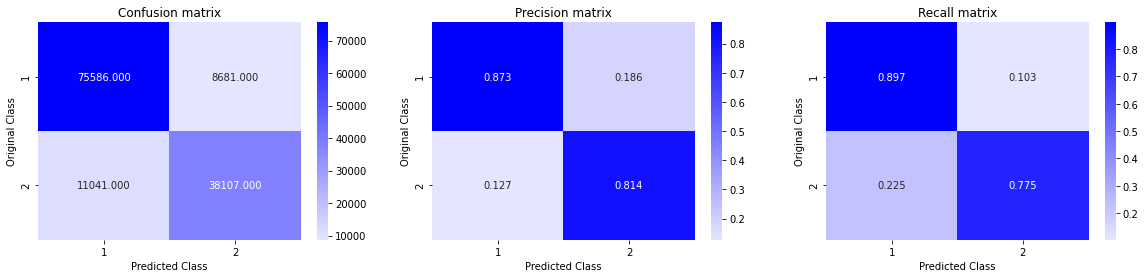

In [14]:
plot_confusion_matrix(y_test, predict_y.round())

# Saving Model Using Pickel

In [0]:
# save the model to disk
import pickle
filepath = '/content/drive/My Drive/Case Studies/Quora Question Pairs/finalized_model.sav'
pickle.dump(model, open(filepath, 'wb'))

# Loading Model from using Pickel

In [0]:
# load the model from disk
#loaded_model = pickle.load(open(filepath, 'rb'))
result = loaded_model.score(X_test, Y_test)
#print(result)